In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# FIP계산에 쓰일 계수인 C는 STATIZ사이트에서 cFIP 크롤링해서 사용
import requests
from bs4 import BeautifulSoup

req = requests.get('http://www.statiz.co.kr/constant.php')
html = req.text
soup = BeautifulSoup(html, 'html.parser')
tables = soup.select('body > div.wrapper > div.content-wrapper > div > section.content > div > div.col-md-12.col-xs-12.col-sm-12.col-lg-9 > div > div > div > div.box-body.no-padding.table-responsive > table')
table = tables[0]

table_html=str(table)
table_df_list=pd.read_html(table_html)
table_df = table_df_list[0]

idx = table_df.loc[0:4, ['연도', 'cFIP']]
idx.rename(columns = {'연도':'GYEAR'}, inplace = True)

## 사칙연산 앞에 replace(nan, 0) 추가

In [3]:
def add_variables(data, year):
    data = pd.read_csv(data)
    data['H1']= data['HIT']-data['H2']-data['H3']-data['HR']
    
    data['CUM_ER'] = None
    data['CUM_INN2'] = None
    data['CUM_KK'] = None
    data['CUM_BB'] = None
    data['CUM_HIT'] = None
    data['CUM_HR'] = None
    data['CUM_AB'] = None
    data['CUM_SF'] = None
    data['CUM_HP'] = None
    data['CUM_R'] = None
    data['CUM_H1']= None
    data['CUM_H2']= None
    data['CUM_H3']= None
    data['GYEAR']=None
    
    data.loc[data['G_ID'].str.contains('%d' % year), 'GYEAR'] = year
    data = pd.merge(data, idx, on='GYEAR')
    
    data = data.sort_values(by=['T_ID', 'GDAY_DS'])
    data= data.drop('GYEAR', axis=1 )
    
    temp = []
    
    for i in range(len(data['T_ID'].unique())):
        temp.append(list(data['T_ID']).index(data['T_ID'].unique()[i]))
    
    temp.append(len(data))

    for i in range(len(data['T_ID'].unique())):
        for j in range(temp[i], temp[i+1]):
            if j == temp[i]:
                data.iloc[j, 35] = data.iloc[j, 30]
                data.iloc[j, 36] = data.iloc[j, 9]
                data.iloc[j, 37] = data.iloc[j, 24]
                data.iloc[j, 38] = data.iloc[j, 21]
                data.iloc[j, 39] = data.iloc[j, 13]
                data.iloc[j, 40] = data.iloc[j, 16]
                data.iloc[j, 41] = data.iloc[j, 12]
                data.iloc[j, 42] = data.iloc[j, 20]
                data.iloc[j, 43] = data.iloc[j, 23]
                data.iloc[j, 44] = data.iloc[j, 29]
                data.iloc[j, 45] = data.iloc[j, 34]
                data.iloc[j, 46] = data.iloc[j, 14]
                data.iloc[j, 47] = data.iloc[j, 15]

            else :
                data.iloc[j, 35] = data.iloc[j, 30]+ data.iloc[j-1,35]
                data.iloc[j, 36] = data.iloc[j, 9]+ data.iloc[j-1, 36]
                data.iloc[j, 37] = data.iloc[j, 24] + data.iloc[j-1, 37]
                data.iloc[j, 38] = data.iloc[j, 21] + data.iloc[j-1, 38]
                data.iloc[j, 39] = data.iloc[j, 13] + data.iloc[j-1, 39]
                data.iloc[j, 40] = data.iloc[j, 16] + data.iloc[j-1, 40]
                data.iloc[j, 41] = data.iloc[j, 12] + data.iloc[j-1, 41]
                data.iloc[j, 42] = data.iloc[j, 20] + data.iloc[j-1, 42]
                data.iloc[j, 43] = data.iloc[j, 23] + data.iloc[j-1, 43]
                data.iloc[j, 44] = data.iloc[j, 29] + data.iloc[j-1, 44]
                data.iloc[j, 45] = data.iloc[j, 34] + data.iloc[j-1, 45]
                data.iloc[j, 46] = data.iloc[j, 14] + data.iloc[j-1, 46]
                data.iloc[j, 47] = data.iloc[j, 15] + data.iloc[j-1, 47]

    
    data = data.sort_index()
    
    
    data['CUM_K/9'] = 9*data['CUM_KK']/(data['CUM_INN2']/3)
    data['CUM_BB/9'] = 9*data['CUM_BB']/(data['CUM_INN2']/3)
    data['CUM_K/BB'] = data['CUM_KK']/data['CUM_BB']
    data['CUM_OAVG'] = data['CUM_HIT']/data['CUM_AB']
    data['CUM_OOBP'] = (data['CUM_HIT'] + data['CUM_BB'] + data['CUM_HP'])/(data['CUM_AB'] + data['CUM_BB'] +data['CUM_HP'] + data['CUM_SF'])
    data['CUM_OSLG'] = (data['CUM_H1'] + 2*data['CUM_H2'] + 3*data['CUM_H3'] + 4*data['CUM_HR'])/data['CUM_AB']
    
    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data['CUM_OOPS'] = data['CUM_OOBP'] + data['CUM_OSLG']
    data['CUM_WHIP'] = (data['CUM_HIT'] + data['CUM_BB'])/(data['CUM_INN2']/3)
    data['CUM_BABIP'] = (data['CUM_HIT'] - data['CUM_HR'])/(data['CUM_AB'] - data['CUM_KK'] - data['CUM_HR'] + data['CUM_SF'])
    data['CUM_DICE']= 3.00 + (13*data['CUM_HR'] + 3*(data['CUM_BB'] + data['HP']) - 2*data['CUM_KK'])/(data['CUM_INN2']/3)
    data['CUM_ERA'] = 9*data['CUM_ER']/(data['CUM_INN2']/3)
    data['CUM_RA9'] = 9 * data['CUM_R']/(data['CUM_INN2']/3)
    data['CUM_FIP'] = data['cFIP'] + (13*data['CUM_HR'] + 3*(data['CUM_BB'] + data['CUM_HP']) - 2*data['CUM_KK'])/(data['CUM_INN2']/3)
    data['CUM_kFIP'] = data['cFIP'] + (14* data['CUM_HR'] + 3*(data['CUM_BB'] + data['CUM_HP']) - data['CUM_KK'])/(data['CUM_INN2']/3)
    data['CUM_HR/9'] = 9 * data['CUM_HR']/(data['CUM_INN2']/3)
    data['CUM_H/9'] = 9 * data['CUM_HIT']/(data['CUM_INN2']/3)

    data['K/9'] = 9*data['KK']/(data['INN2']/3)
    data['BB/9'] = 9*data['BB']/(data['INN2']/3)
    data['K/BB'] = data['KK']/data['BB']
    data['OAVG'] = data['HIT']/data['AB']
    data['OOBP'] = (data['HIT'] + data['BB'] + data['HP'])/(data['AB'] + data['BB'] +data['HP'] + data['SF'])
    data['OSLG'] = (data['H1'] + 2*data['H2'] + 3*data['H3'] + 4*data['HR'])/data['AB']
    
    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data['OOPS'] = data['OOBP'] + data['OSLG']
    data['WHIP'] = (data['HIT'] + data['BB'])/(data['INN2']/3)
    data['BABIP'] = (data['HIT'] - data['HR'])/(data['AB'] - data['KK'] - data['HR'] + data['SF'])
    data['DICE']= 3.00 + (13*data['HR'] + 3*(data['BB'] + data['HP']) - 2*data['KK'])/(data['INN2']/3)
    data['ERA'] = 9*data['ER']/(data['INN2']/3)
    data['RA9'] = 9 * data['R']/(data['INN2']/3)
    data['FIP'] = data['cFIP'] + (13*data['HR'] + 3*(data['BB'] + data['HP']) - 2*data['KK'])/(data['INN2']/3)
    data['kFIP'] = data['cFIP'] + (14* data['HR'] + 3*(data['BB'] + data['HP']) - data['KK'])/(data['INN2']/3)
    data['HR/9'] = 9 * data['HR']/(data['INN2']/3)
    data['H/9'] = 9 * data['HIT']/(data['INN2']/3)

    data = data.replace([np.nan, np.inf, -np.inf], 0)
    data = data.drop(['CUM_ER','CUM_INN2','CUM_KK','CUM_BB','CUM_HIT','CUM_HR','CUM_AB','CUM_SF','CUM_HP','CUM_R','CUM_H1','CUM_H2','CUM_H3','cFIP'],axis=1)
    tmp = data.loc[:,['H1']]
    data = data.drop(['H1'],axis=1)
    tmp1 = data.iloc[:,:14]
    tmp2 = data.iloc[:,14:]
    data = pd.concat([tmp1, tmp],axis=1)
    data = pd.concat([data,tmp2],axis=1)
    data.to_csv('team_pitcher_%d.csv' % year, index=False)

In [5]:
add_variables('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2016.csv', 2016)

In [6]:
add_variables('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2017.csv', 2017)

In [7]:
add_variables('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2018.csv', 2018)

In [8]:
add_variables('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2019.csv', 2019)

In [9]:
add_variables('2020빅콘테스트_스포츠투아이_제공데이터_팀투수_2020.csv', 2020)

## pitcher 데이터 다 병합

In [10]:
data1 = pd.read_csv('team_pitcher_2016.csv')
data2 = pd.read_csv('team_pitcher_2017.csv')
data3 = pd.read_csv('team_pitcher_2018.csv')
data4 = pd.read_csv('team_pitcher_2019.csv')
data5 = pd.read_csv('team_pitcher_2020.csv')

data = pd.concat([data1,data2],axis=0)
data = pd.concat([data, data3],axis=0)
data = pd.concat([data, data4],axis=0)
data = pd.concat([data, data5],axis=0)

## 상관관계 분석

In [11]:
def cor(data):
    data = data
    col = ['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'HEADER_NO', 'TB_SC', 'CG_CK',
       'WLS', 'HOLD', 'INN2', 'BF']
    data_cor = data.drop(col,axis=1)
    fig, ax = plt.subplots(figsize=(30,30))
    ax = sns.heatmap(data_cor.corr(), annot=True, fmt='.1f',linewidth=1)

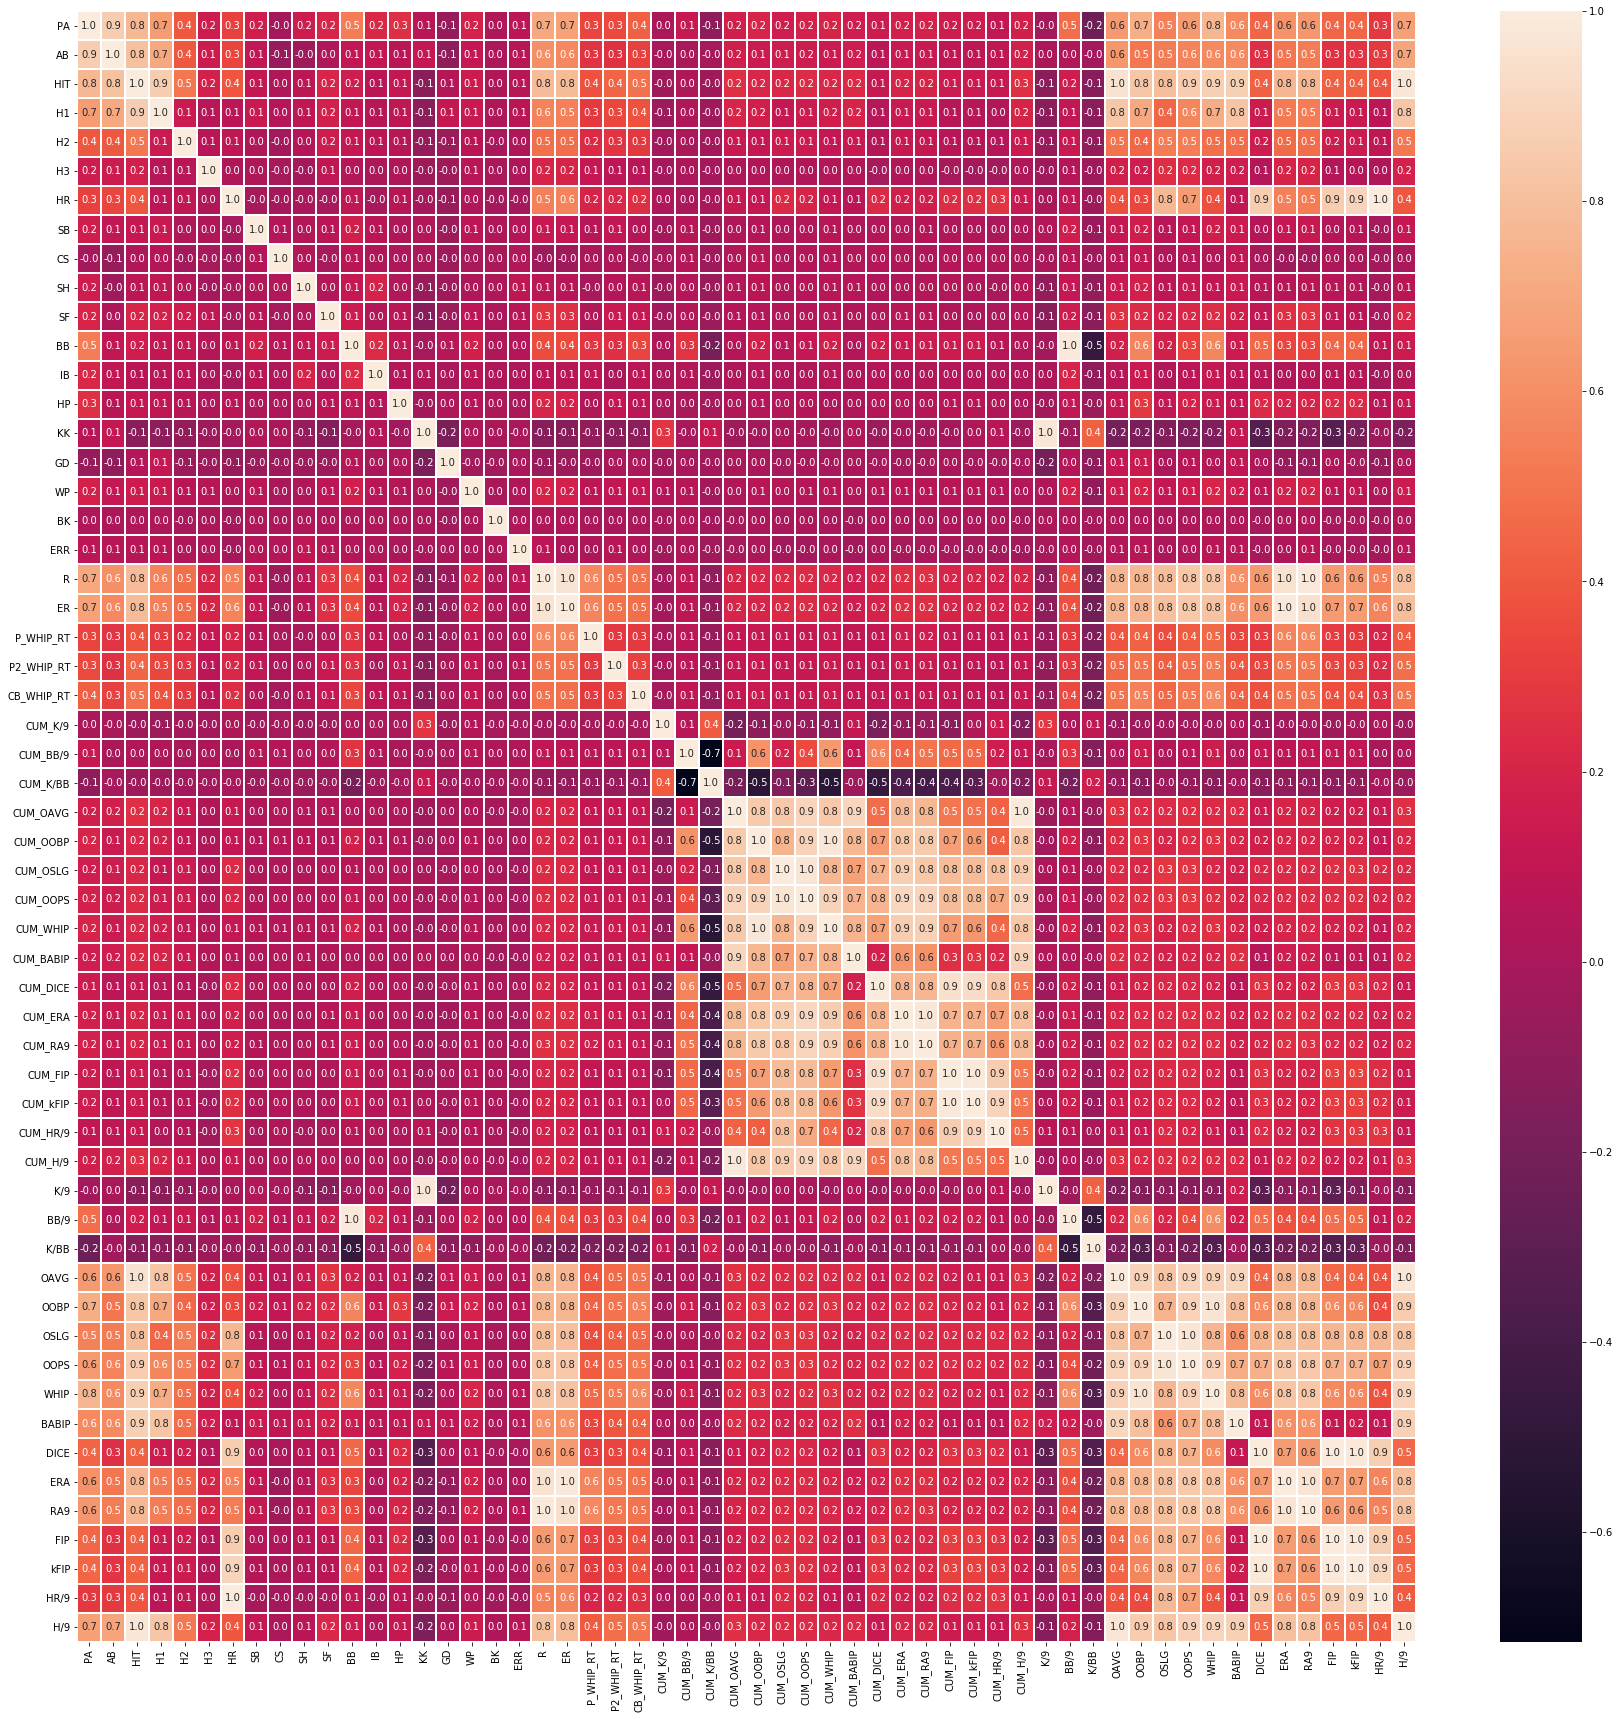

In [12]:
cor(data)

### 상관관계를 보면 R(실점)과의 상관관계가 높게 나오는 경우
* 팀별 누적으로 구한 파생변수보다 경기별로 구한 파생변수 간의 상관관계가 더 높게 나옴
* 따라서 누적으로 만든 파생변수를 제외하고 다시 바라보겠음

In [13]:
cum_col = ['CUM_K/9',
       'CUM_BB/9', 'CUM_K/BB', 'CUM_OAVG', 'CUM_OOBP', 'CUM_OSLG', 'CUM_OOPS',
       'CUM_WHIP', 'CUM_BABIP', 'CUM_DICE', 'CUM_ERA', 'CUM_RA9', 'CUM_FIP',
       'CUM_kFIP', 'CUM_HR/9', 'CUM_H/9']
data = data.drop(cum_col,axis=1)

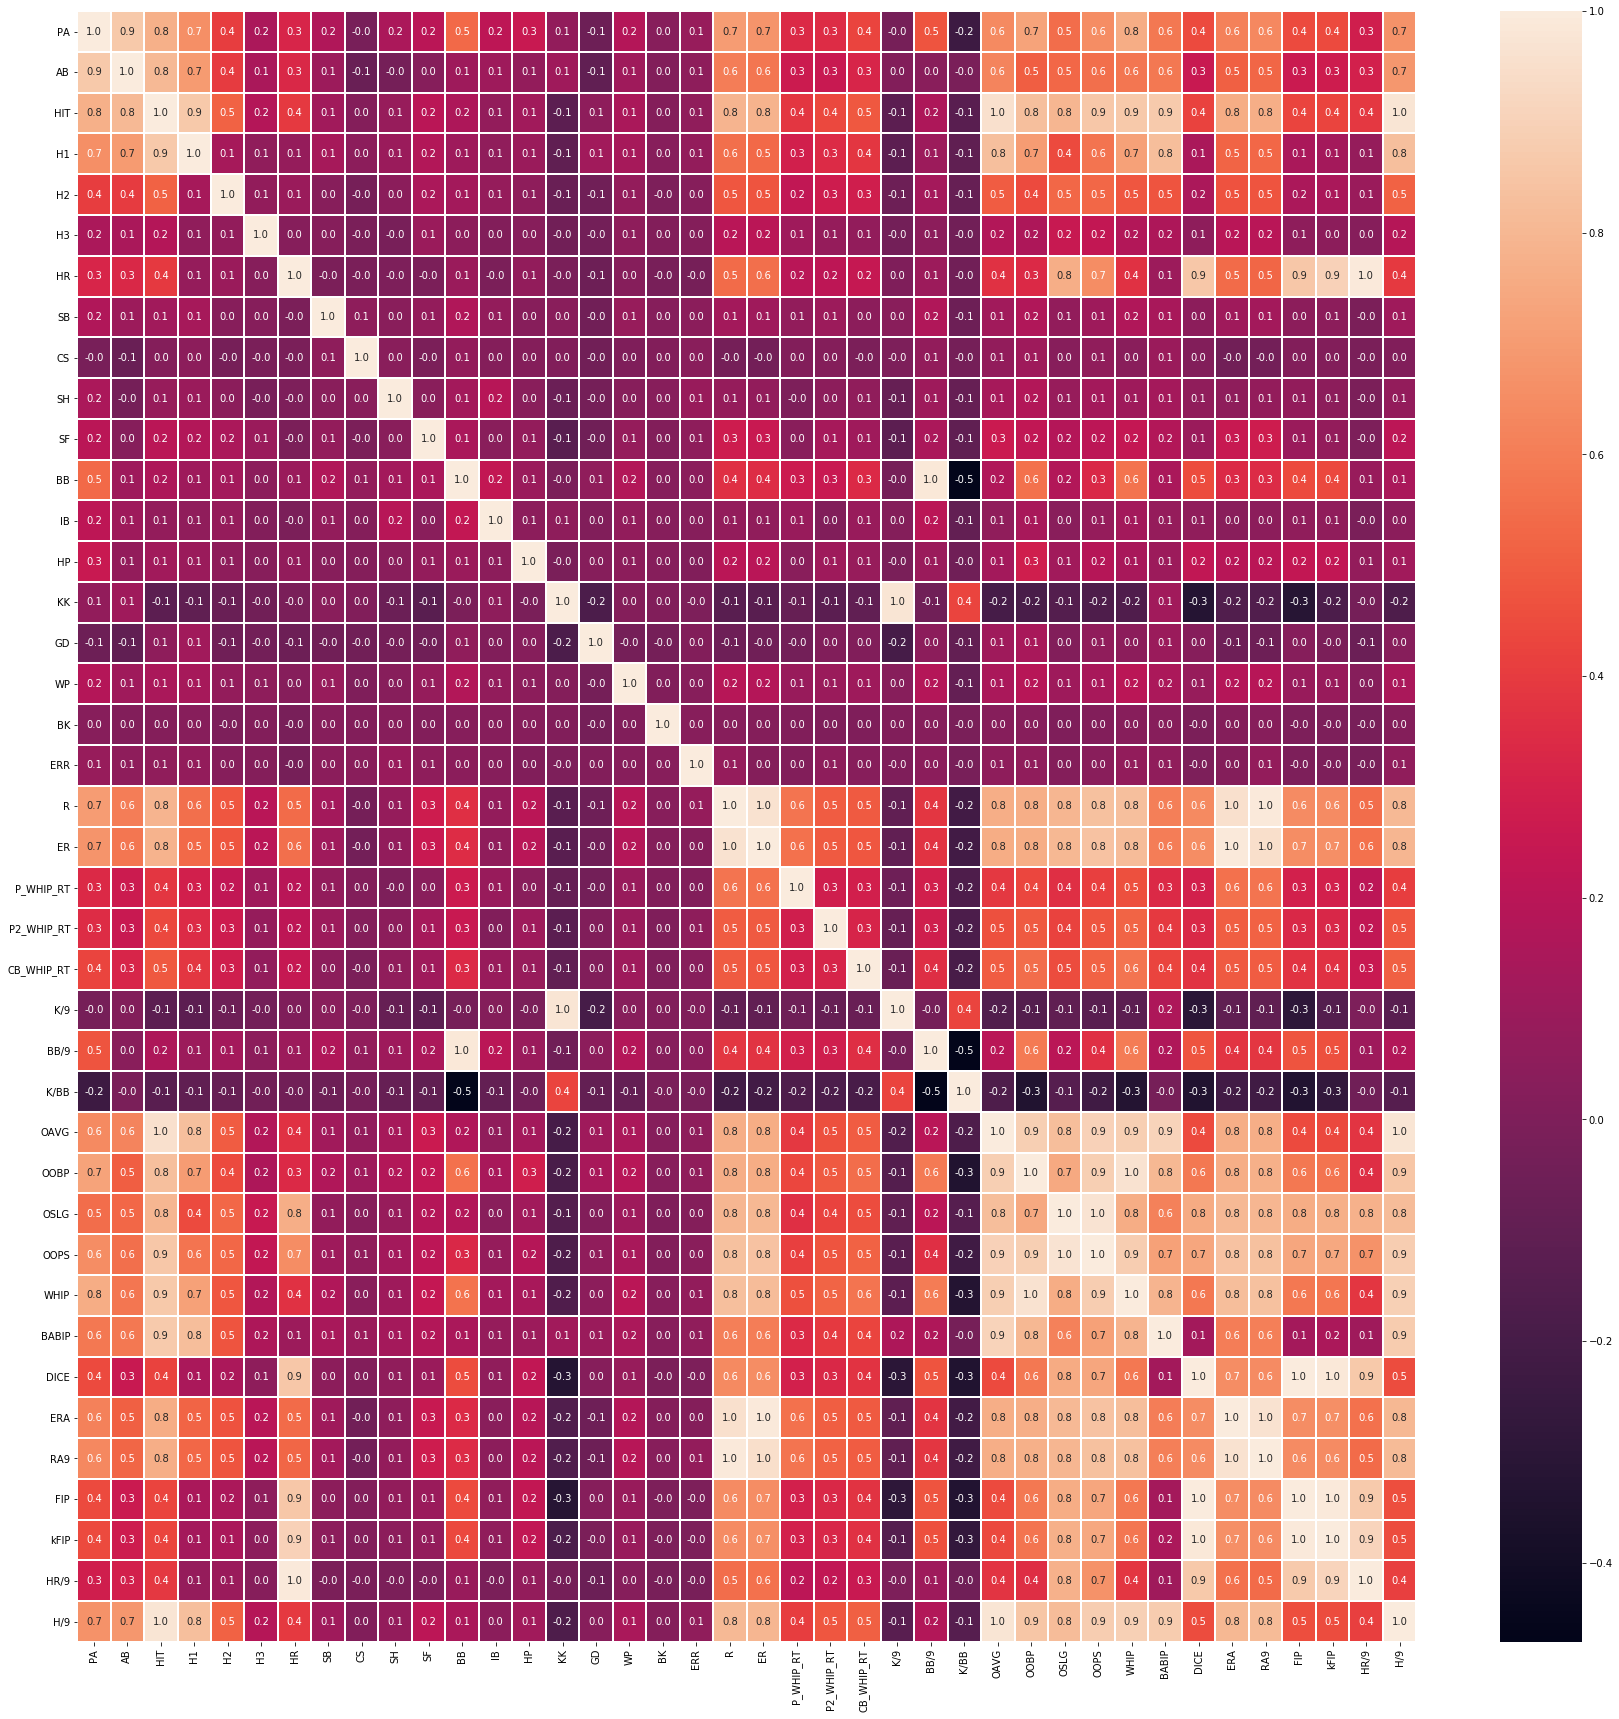

In [14]:
cor(data)

## 만든 파생변수들 간의 상관관계 높은 경우
* kFIP, FIP, DICE => 서로 간의 상관관계 : 1, 실점과의 상관관계 : 0.6으로 동일 => kFIP 사용
* OAVG, OOBP, OSLG, OOPS, WHIP => 실점과의 상관관계 = 0.8로 동일 => WHIP or OOPS 사용

### 파생변수 중 선택한 것 kFIP, OOPS, WHIP, BABIP, K/BB

In [15]:
data = data.drop(['K/9','BB/9','OAVG','OOBP','OSLG','DICE','ERA','RA9','FIP','HR/9','H/9'],axis=1)

## Scaling
* 타수, 안타, 1루타 ~ 홈런, 희타, 희플, 볼넷, 사구, 삼진 등은 타석에 포함됨 => 타석으로 나누어서 경기별로 scaling 시킴

* 타석, P_WHIP_RT, K/BB, kFIP, WHIP, ERR => MinMax 사용 (OOPS,BABIP는 이미 0~1사이)

* 폭투, 보크- 대부분의 경기가 0(70% 이상), 0이 아닌 값들 1,2가 대부분 => dummy화 해봄

In [16]:
# 타석으로 나누는 작업
col = ['AB','HIT','H1','H2','H3','HR','SH','SF','BB','IB','HP','KK']
for i in range(len(col)):
    data.loc[:,col[i]] = data.loc[:,col[i]]/data.loc[:,'PA']

In [17]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data[['PA','P_WHIP_RT','P2_WHIP_RT','CB_WHIP_RT','K/BB','kFIP','WHIP','ERR']])
data.loc[:,['PA','P_WHIP_RT','P2_WHIP_RT','CB_WHIP_RT','K/BB','kFIP','WHIP','ERR']] = scaler.transform(data[['PA','P_WHIP_RT','P2_WHIP_RT','CB_WHIP_RT','K/BB','kFIP','WHIP','ERR']])

In [18]:
print(data.WP.value_counts())
print(data.BK.value_counts())
print(data.ERR.value_counts())

0    4135
1    1704
2     443
3      98
4      19
5       1
Name: WP, dtype: int64
0    6199
1     197
2       4
Name: BK, dtype: int64
0.000000    5837
0.333333     538
0.666667      23
1.000000       2
Name: ERR, dtype: int64


In [19]:
# dummy화
data['WP'] = data['WP'].replace([1,2,3,4,5],1)        
data['BK'] = data['BK'].replace([1,2],1)

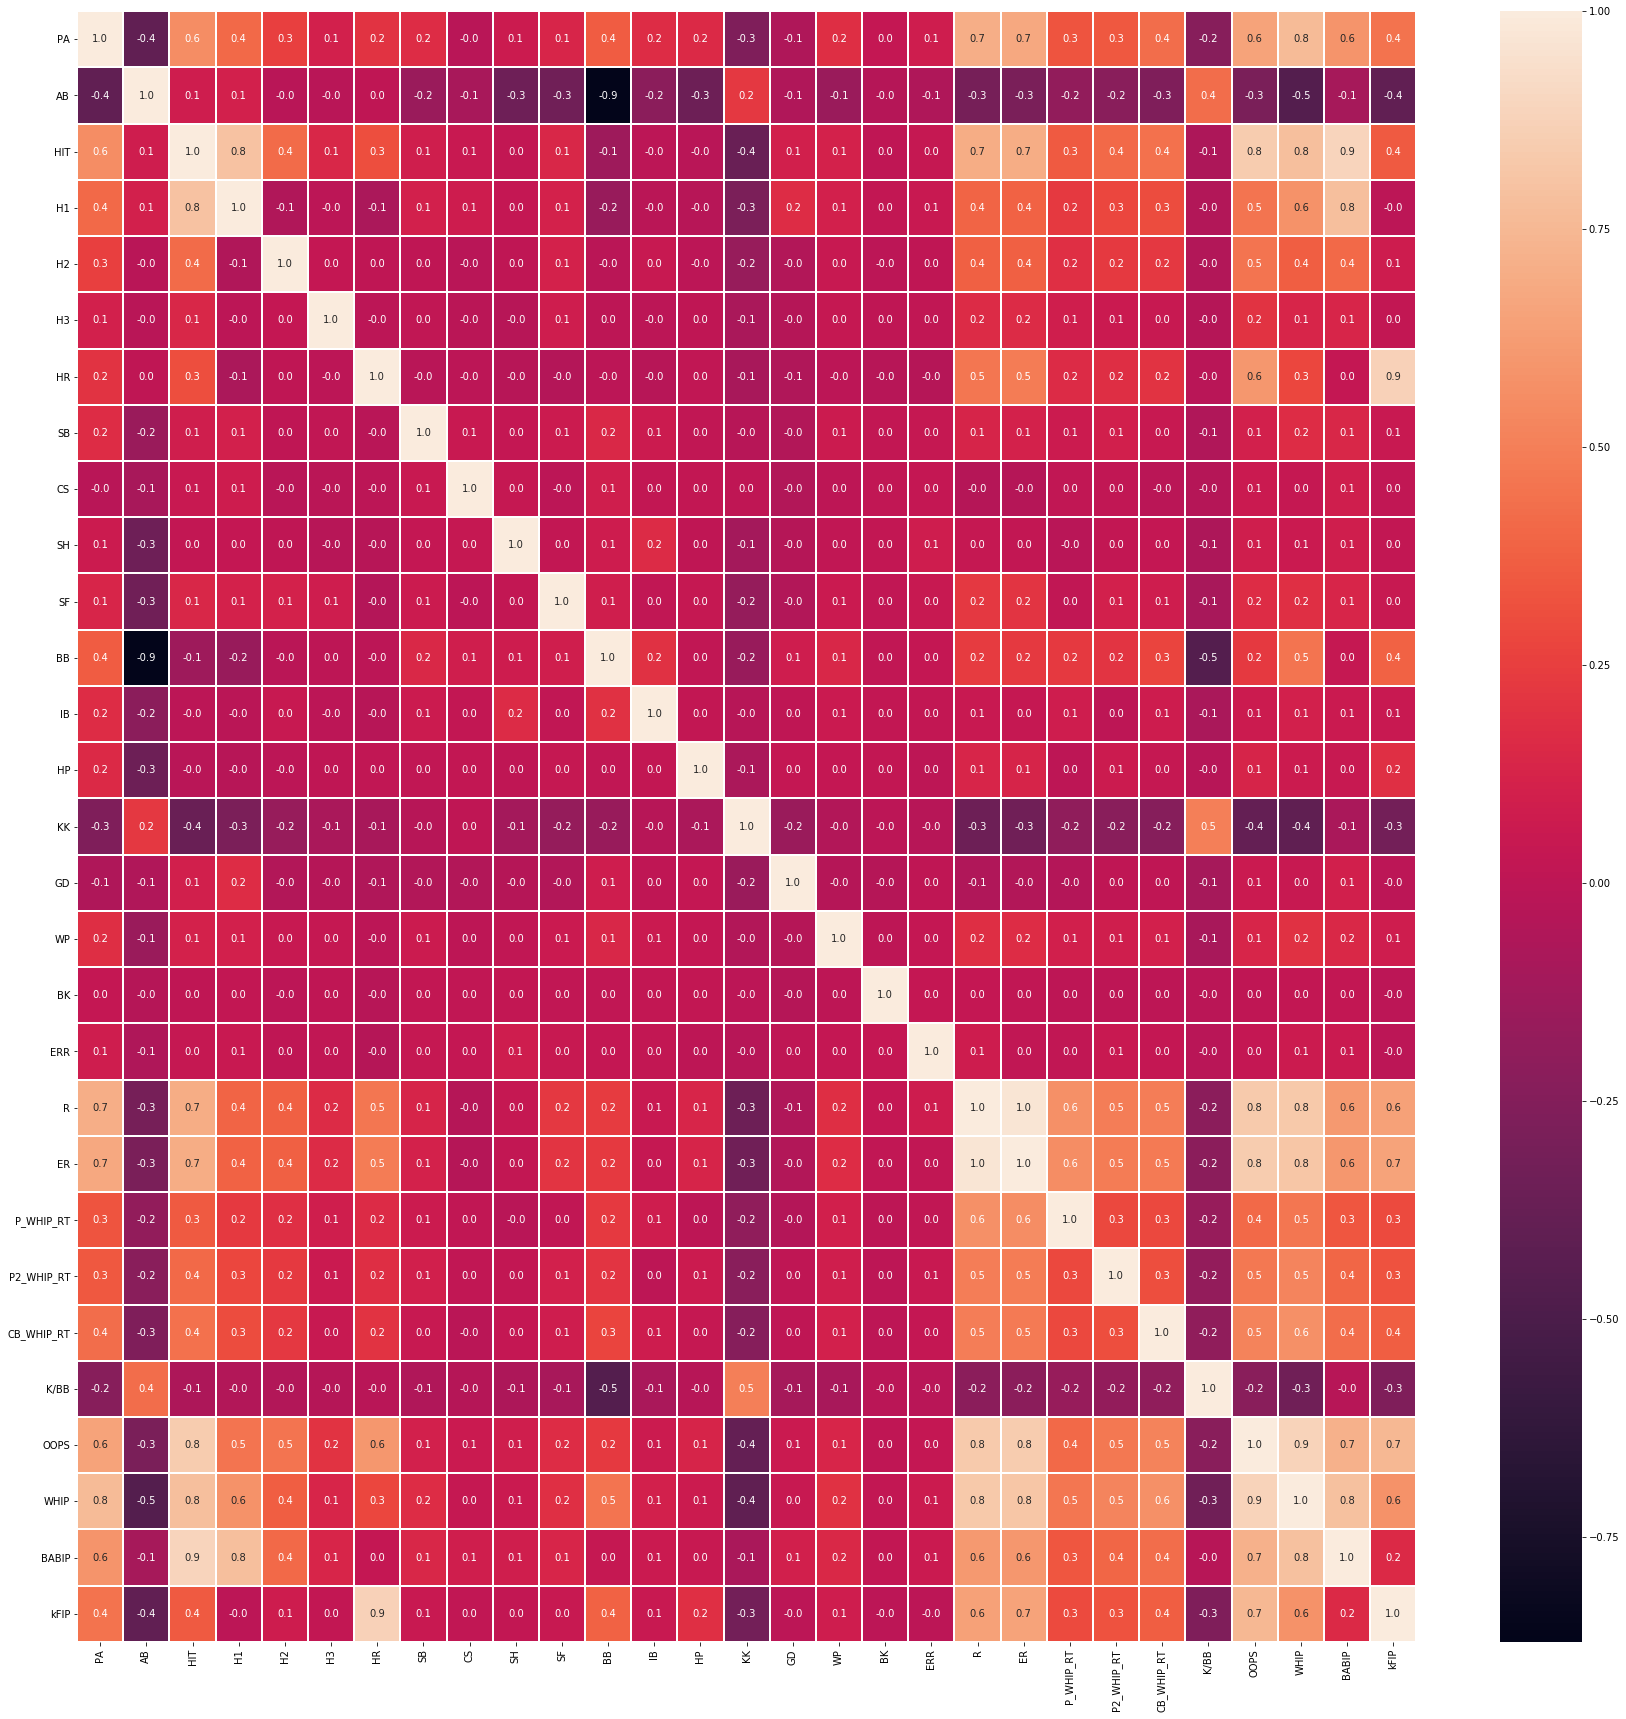

In [20]:
cor(data)

In [21]:
# HEADER_NO, TB_SC dummy화
data = pd.concat([data, pd.get_dummies(data['HEADER_NO'], prefix='HEADER_NO', drop_first=True)], axis=1)
data = pd.concat([data, pd.get_dummies(data['TB_SC'], prefix='TB_SC', drop_first=True)], axis=1)
data = data.drop(['HEADER_NO', 'TB_SC'], axis=1)

## 변수 중요도 확인

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = data.drop(['G_ID', 'GDAY_DS', 'T_ID', 'VS_T_ID', 'CG_CK',
       'WLS', 'HOLD', 'INN2', 'BF'],axis=1)
X = X.drop(['SB','CS','IB','GD','R','ER'],axis=1)
# SB, CS : 도루 관련 지표인데 어떻게 넣을지 모르겠음...
# IB : 고의4구 -> 볼넷에 다 포함되어 있음
# GD ; 병살타 -> 어떻게 쓸지 모르겠음

y = data.R

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [26]:
rf.score(X_train, y_train)

0.9789188203345766

In [27]:
rf.score(X_test, y_test)

0.8413577316570382

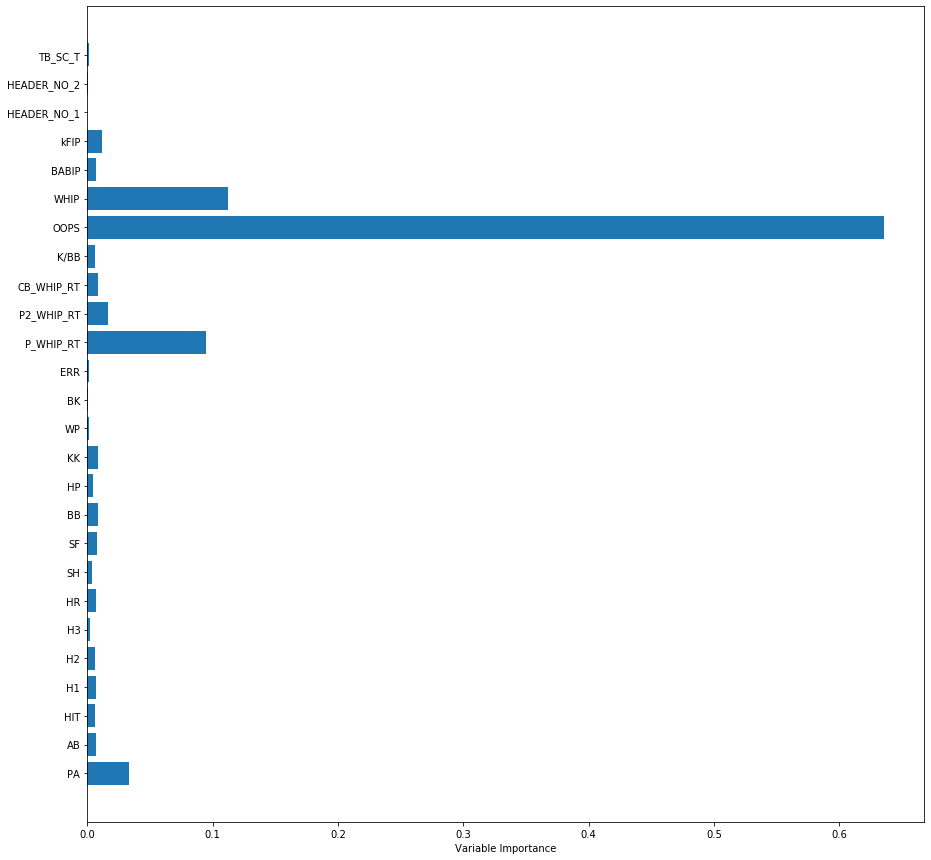

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
ax.barh(X_test.columns, rf.feature_importances_)
ax.set_xlabel('Variable Importance')
plt.show()

In [29]:
data.to_csv('pitcher_scaled_revised.csv')

## 중요!! 고려사항!!
* 폭투, 보크 -> dummy화 시켰는데 -> dummy vs MinMaxScaler (어떤 것이 더 나은지 고려 필요)
; 실책은 minmax로 바꿈
* 이닝수, 투구 수, 도루 성공, 도루 실패, 고의사구, 병살타 -> 활용방안이 안 보여 X에서 제외했는데 어떤지 의견 필요